**EMOTION DETECTION AND ANALYSIS OF DIFFERENT MENTAL HEALTH CONDITIONS**

Emotions play a critical role in mental health, and understanding emotional expressions can offer deep insights into an individual’s mental state, aiding in early diagnosis. This project aims to develop a model capable of detecting emotions in textual data using Machine Learning and Natural Language Processing (NLP).

##Dataset Acquisition and Setup

In [1]:
# Mount Google Drive to access files and save data directly from/to Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Installing necessary libraries
!pip install datasets
!pip uninstall transformers tokenizers -y
!pip install transformers==4.28.0 tokenizers==0.13.3
!pip install sentence-transformers==2.2.2
!pip install tensorflow==2.12.0
!pip install keras==2.12.0

Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
Found existing installation: tokenizers 0.13.3
Uninstalling tokenizers-0.13.3:
  Successfully uninstalled tokenizers-0.13.3
  Using cached transformers-4.28.0-py3-none-any.whl.metadata (109 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)


In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys, os
import json
import random

# Installing libraries for text preprocessing
!pip install emoji
!pip install contractions

# Text processing libraries
import emoji
import re
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
# Download model for preprocessing
!python -m spacy download en_core_web_sm -q
#Import English using en_core_web_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()
import json
from pprint import pprint
# Scikit-Learn packages
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support
from transformers import TFBertModel, BertTokenizerFast, BertConfig
from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight

# Keras and TensorFlow packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import binary_crossentropy

#For displaying Output
from IPython.display import display, HTML


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Load the GoEmotions dataset
ds = load_dataset("google-research-datasets/go_emotions", "simplified")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
# Access dataset splits
df_train = pd.DataFrame(ds['train'])
df_val = pd.DataFrame(ds['validation'])
df_test = pd.DataFrame(ds['test'])

# Save to Google Drive
save_dir = "/content/drive/MyDrive/Dissertation/Data/"
df_train.to_csv(save_dir + "train.tsv", sep='\t', index=False, header=False)
df_val.to_csv(save_dir + "val.tsv", sep='\t', index=False, header=False)
df_test.to_csv(save_dir + "test.tsv", sep='\t', index=False, header=False)

print("TSV files saved to Google Drive.")


TSV files saved to Google Drive.


##Exploratory Data Analysis

In [4]:
# Importing the files
df_train = pd.read_csv('/content/drive/MyDrive/Dissertation/Data/train.tsv', sep='\t', header=None, names=['Text', 'Emotion_indices', 'Id']).drop('Id', axis=1)
df_val = pd.read_csv('/content/drive/MyDrive/Dissertation/Data/val.tsv', sep='\t', header=None, names=['Text', 'Emotion_indices', 'Id']).drop('Id', axis=1)
df_test = pd.read_csv('/content/drive/MyDrive/Dissertation/Data/test.tsv', sep='\t', header=None, names=['Text', 'Emotion_indices', 'Id']).drop('Id', axis=1)

# Preview of data
display(df_train.head())

,Text,Emotion_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


**1. Basic Information About the GoEmotions Dataset**

In [5]:
# Display information about data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             43410 non-null  object
 1   Emotion_indices  43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


In [6]:
# Define the number of samples in train, validation and test dataset
train_size = df_train.shape[0]
val_size= df_val.shape[0]
test_size = df_test.shape[0]

# Define the total number of samples
Total_size = train_size + val_size + test_size

In [7]:
# Shape of train, validation and test datasets
print("Number of samples in Train data:", train_size)
print("\nNumber of samples in Validation data:", val_size)
print("\nNumber of samples in Test data:", test_size)
print("\nThe total number of samples:", Total_size)

print("\n\nThe number of samples in Train data represents {:.2f}% of overall data".format(train_size/Total_size*100))
print("\nThe number of samples in Validation data represents {:.2f}% of overall data".format(val_size/Total_size*100))
print("\nThe number of samples in Test data represents {:.2f}% of overall data".format(test_size/Total_size*100))


Number of samples in Train data: 43410

Number of samples in Validation data: 5426

Number of samples in Test data: 5427

The total number of samples: 54263


The number of samples in Train data represents 80.00% of overall data

The number of samples in Validation data represents 10.00% of overall data

The number of samples in Test data represents 10.00% of overall data


In [8]:
# Loading emotion labels
with open("/content/drive/MyDrive/Dissertation/Data/emotions.txt", "r") as file:
    Emotions = file.read().split("\n")

for emo in Emotions:
    print(emo)

# Number of emotions
print("\nThere are {} emotions in the dataset including 'Neutral'".format(len(Emotions)))

admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral

There are 28 emotions in the dataset including 'Neutral'


**2. OneHot encoding for multi-label classification**

In [9]:
# Concatenating the 3 datasets for labels preprocessing
GoEmotions_df = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

# Preview of data
display(GoEmotions_df.head(3))

print(GoEmotions_df.shape)

,Text,Emotion_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2


(54263, 2)


In [10]:
# Convert emotion indices into a list of indices
GoEmotions_df['Emotion_indices'] = GoEmotions_df['Emotion_indices'] .apply(lambda x: x.split(','))

# Preview of data
display(GoEmotions_df.head(3))

,Text,Emotion_indices
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]


In [11]:
# Defining a function that maps each index to emotion labels
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(Emotions[int(i)])
    return arr

# Applying the function
GoEmotions_df['Emotion_labels'] = GoEmotions_df['Emotion_indices'].apply(idx2class)

# Preview of data
display(GoEmotions_df.head(3))

,Text,Emotion_indices,Emotion_labels
0,My favourite food is anything I didn't have to...,[27],[neutral]
1,"Now if he does off himself, everyone will thin...",[27],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],[anger]


In [12]:
# Preview of data
for emo in Emotions:
    GoEmotions_df[emo] = np.zeros((len(GoEmotions_df),1))
    GoEmotions_df[emo] = GoEmotions_df['Emotion_labels'].apply(lambda x: 1 if emo in x else 0)


display(GoEmotions_df.head(3))

,Text,Emotion_indices,Emotion_labels,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,[27],[neutral],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],[neutral],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],[anger],0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Keep only the necessary columns
GoEmotions_df = GoEmotions_df.drop(['Emotion_indices','Emotion_labels'], axis=1)

# Display the first 3 rows
display(GoEmotions_df.head(3))

,Text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**3. Text preprocessing**

Text is preprocessed to handle emojis, contractions, acronyms, special characters, etc.

In [43]:
# Creating a preprocessing function to clean text
def preprocess_text(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z])', r'\1 \2', x)

  # Demojize
  x = emoji.demojize(x)

  # Expand contraction
  x = contractions.fix(x)

  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations
  x = re.sub(r"lmao", "laughing my ass off", x)
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x)
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)

  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)
  x = x.strip()

  return x


In [15]:
# Applying the preprocessing function on the dataset
GoEmotions_df["Clean_text"] = GoEmotions_df["Text"].apply(preprocess_text)

# Preview of data
display(GoEmotions_df[['Text', 'Clean_text']].sample(5))


,Text,Clean_text
25233,Totally understand and love this.,totally understand and love this
3009,That they wield to great effect to tell *you* ...,that they wield to great effect to tell you wh...
52950,I’ve not had it happen on mobile but that is b...,i have not had it happen on mobile but that is...
37421,And it's posts like this why HotS is in the po...,and it is posts like this why hots is in the p...
45518,I don't see how this is relevant to this subre...,i do not see how this is relevant to this subr...


In [16]:
# Dropping text column and keeping Clean_text only
GoEmotions_df = GoEmotions_df[ ['Clean_text'] + [ col for col in GoEmotions_df.columns if col not in ['Text', 'Clean_text'] ] ]

# Preview of data
display(GoEmotions_df.head(3))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Again Splitting into Train, Validation and Test datasets

In [17]:
# Building a function that will divide in train, validation and test sets
def get_train_val_test(df):
    train = df.iloc[:train_size, :]
    val = df.iloc[train_size:train_size+val_size, :]
    test = df.iloc[train_size+val_size:train_size+val_size+test_size, :]
    return train, val, test


In [18]:
# Dividing back in train, validation and test datasets
GE_train, GE_val, GE_test= get_train_val_test(GoEmotions_df)
print(GE_train.shape)
print(GE_val.shape)
print(GE_test.shape)

(43410, 29)
(5426, 29)
(5427, 29)


In [19]:
# Save DataFrames to a CSV file
GE_train.to_csv("/content/drive/MyDrive/Dissertation/Data/train_clean.csv", index=False)
GE_val.to_csv("/content/drive/MyDrive/Dissertation/Data/val_clean.csv", index=False)
GE_test.to_csv("/content/drive/MyDrive/Dissertation/Data/test_clean.csv", index=False)


**Labels analysis**

1.  Number of emotions per sample in the dataset

In [ ]:
# Computing the number of labels for each sample
GE_train['Cardinality'] = GE_train.loc[:, Emotions].apply(lambda x: sum(x), axis=1)

# Preview of data
display(GE_train.head(3))

<ipython-input-124-9f515a908f83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GE_train['Cardinality'] = GE_train.loc[:, Emotions].apply(lambda x: sum(x), axis=1)


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Possible number of emotions per sample in dataset
GE_train['Cardinality'].value_counts()

,count
Cardinality,
1,36308
2,6541
3,532
4,28
5,1


Each sample is associated with 1 to 5 emotions, with the majority of samples containing just 1 or 2 emotions.

2 - Number of samples per emotion in the dataset

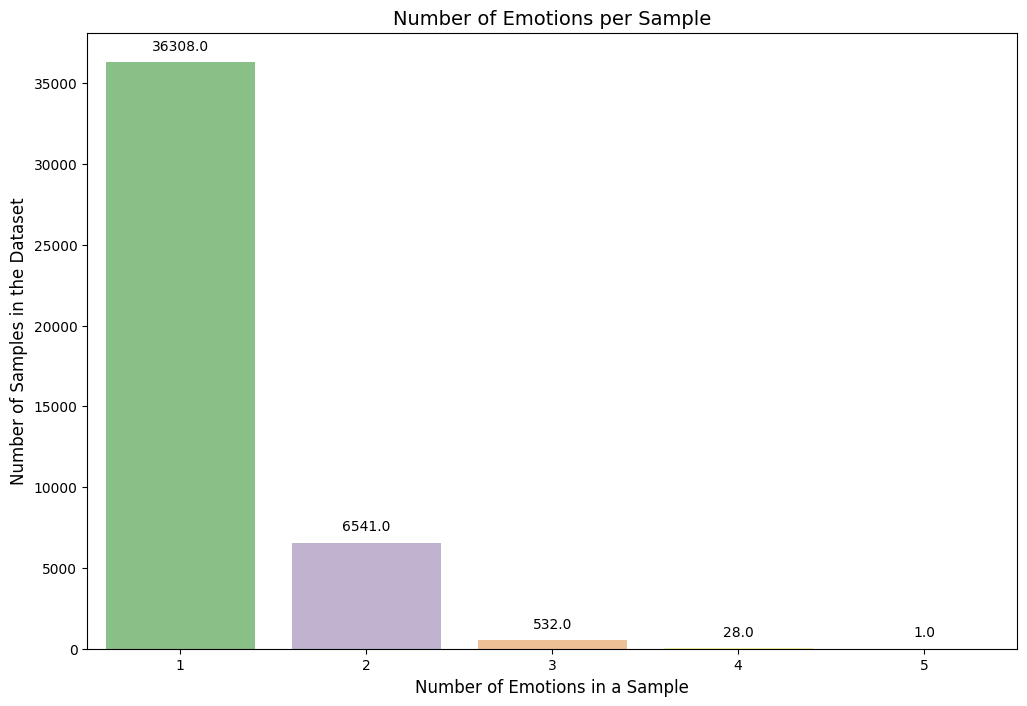

In [ ]:
# Cardinality of GoEmotion labels across the dataset
plt.figure(figsize=(12, 8))

ax = sns.countplot(x='Cardinality', data=GE_train, palette="Accent")

# Annotating the bars with the count values
for p in ax.patches:
    value = p.get_height()
    x = p.get_x() + p.get_width() / 2.0
    y = p.get_height() + 1000  # Adjust position above the bar
    ax.annotate(value, (x, y), ha='center', va='center', fontsize=10)

# Adding titles and labels
plt.title("Number of Emotions per Sample", fontsize=14)
plt.ylabel("Number of Samples in the Dataset", fontsize=12)
plt.xlabel("Number of Emotions in a Sample", fontsize=12)

# Display the plot
plt.show()


In [ ]:
# Computing number of samples per emotion
classes_GE_count = GE_train.loc[:,Emotions].sum(axis=0).sort_values(ascending=False)

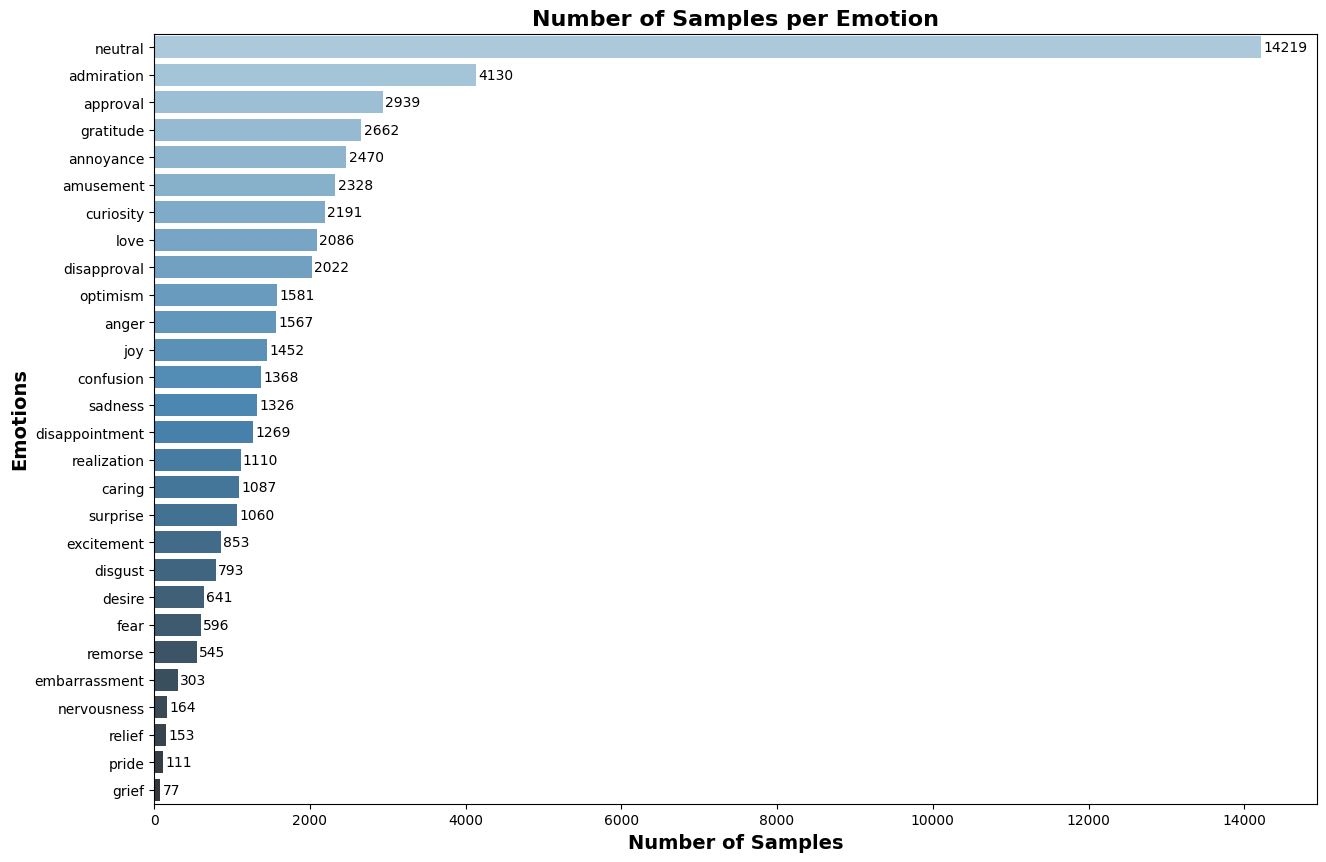

In [ ]:
# Visualizing the number of samples per class
plt.figure(figsize=(15, 10))

# Explicitly passing the palette without hue
ax = sns.barplot(
    x=classes_GE_count.values,
    y=classes_GE_count.index,
    orient='h',
    palette=sns.color_palette("Blues_d", len(classes_GE_count))
)

# Annotate bar values
for p in ax.patches:
    value = int(p.get_width())
    x = p.get_x() + p.get_width() + 30
    y = p.get_y() + p.get_height() / 2
    ax.annotate(value, (x, y), va='center', fontsize=10)

# Titles and labels
plt.title("Number of Samples per Emotion", fontweight='bold', fontsize=16)
plt.ylabel("Emotions", fontweight='bold', fontsize=14)
plt.xlabel("Number of Samples", fontweight='bold', fontsize=14)

# Show the plot
plt.show()


From the graph it is evident that almost 30% of samples are labelled 'Neutral' and only 77 samples have the 'grief' label.

3. Class balance in train, validation and test datasets

 Compute the proportion of emotions in each dataset

In [ ]:
# Defining classes representation for each dataset (GoEmotions)
GE_train_count = (GE_train.loc[:, Emotions].sum(axis=0) / train_size)*100
GE_val_count = (GE_val.loc[:, Emotions].sum(axis=0) / val_size)*100
GE_test_count= (GE_test.loc[:, Emotions].sum(axis=0) / test_size)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[GE_train_count, GE_val_count, GE_test_count]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation', 'Test'], value_name='Percentage')

# Preview of data
display(balance_GE.head())

,Emotion,Dataset,Percentage
0,neutral,Train,32.755126
1,admiration,Train,9.513937
2,approval,Train,6.770329
3,gratitude,Train,6.132228
4,annoyance,Train,5.689933


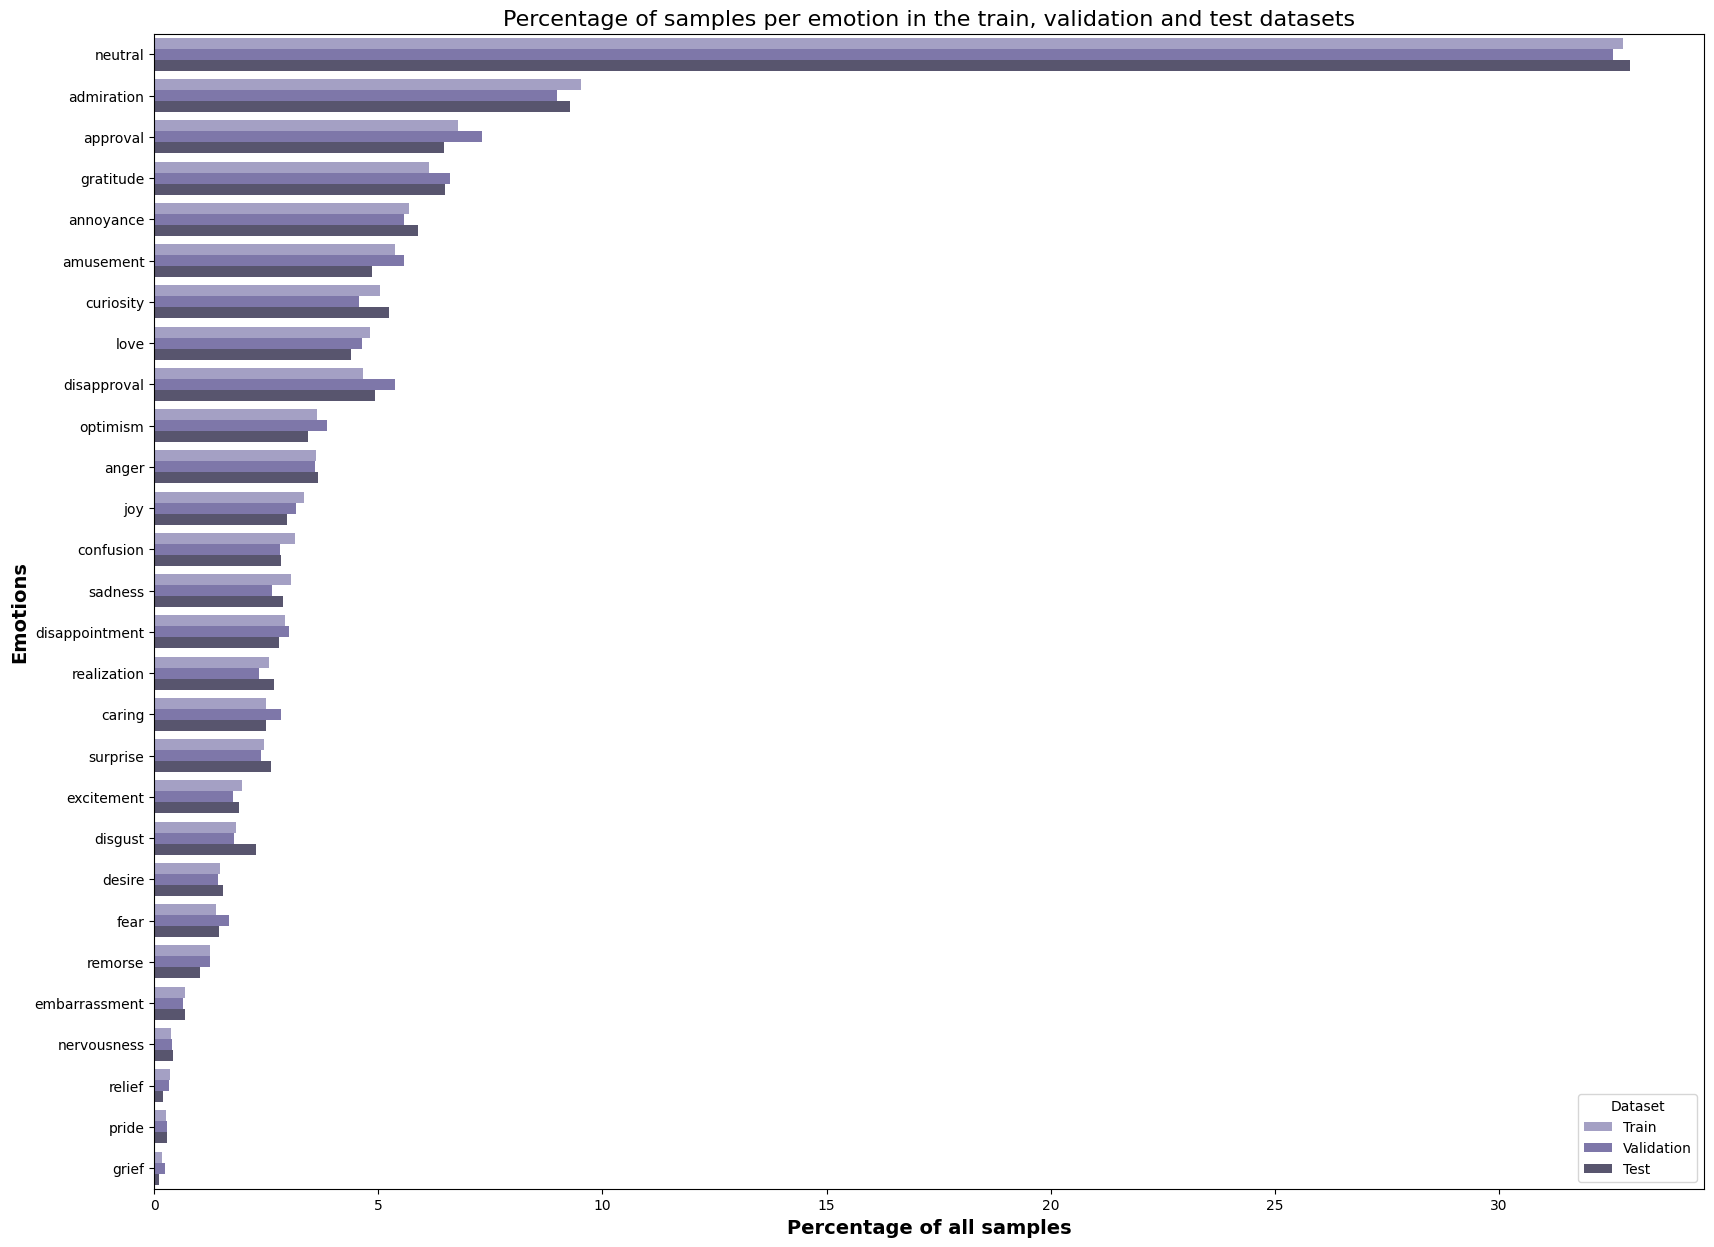

In [ ]:
# Visualization of Class balance

plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="Purples_d")
plt.title("Percentage of samples per emotion in the train, validation and test datasets", fontsize=16)
plt.ylabel("Emotions", fontsize=14, fontweight='bold')
plt.xlabel("Percentage of all samples", fontsize=14, fontweight='bold')
plt.show()

As observed, the proportions of emotions are consistent across the training, validation, and test datasets.

**Words analysis**

Top 5 words per emotion

In [ ]:
# Function to display 5 most frequent words in a series of comments
def plot_frequent_words(comments, axes):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(5) # retrieve the 5 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:5]:
      x.append(word)
      y.append(count)
    sns.barplot(x=y, y=x , ax=axes, palette="Set2")

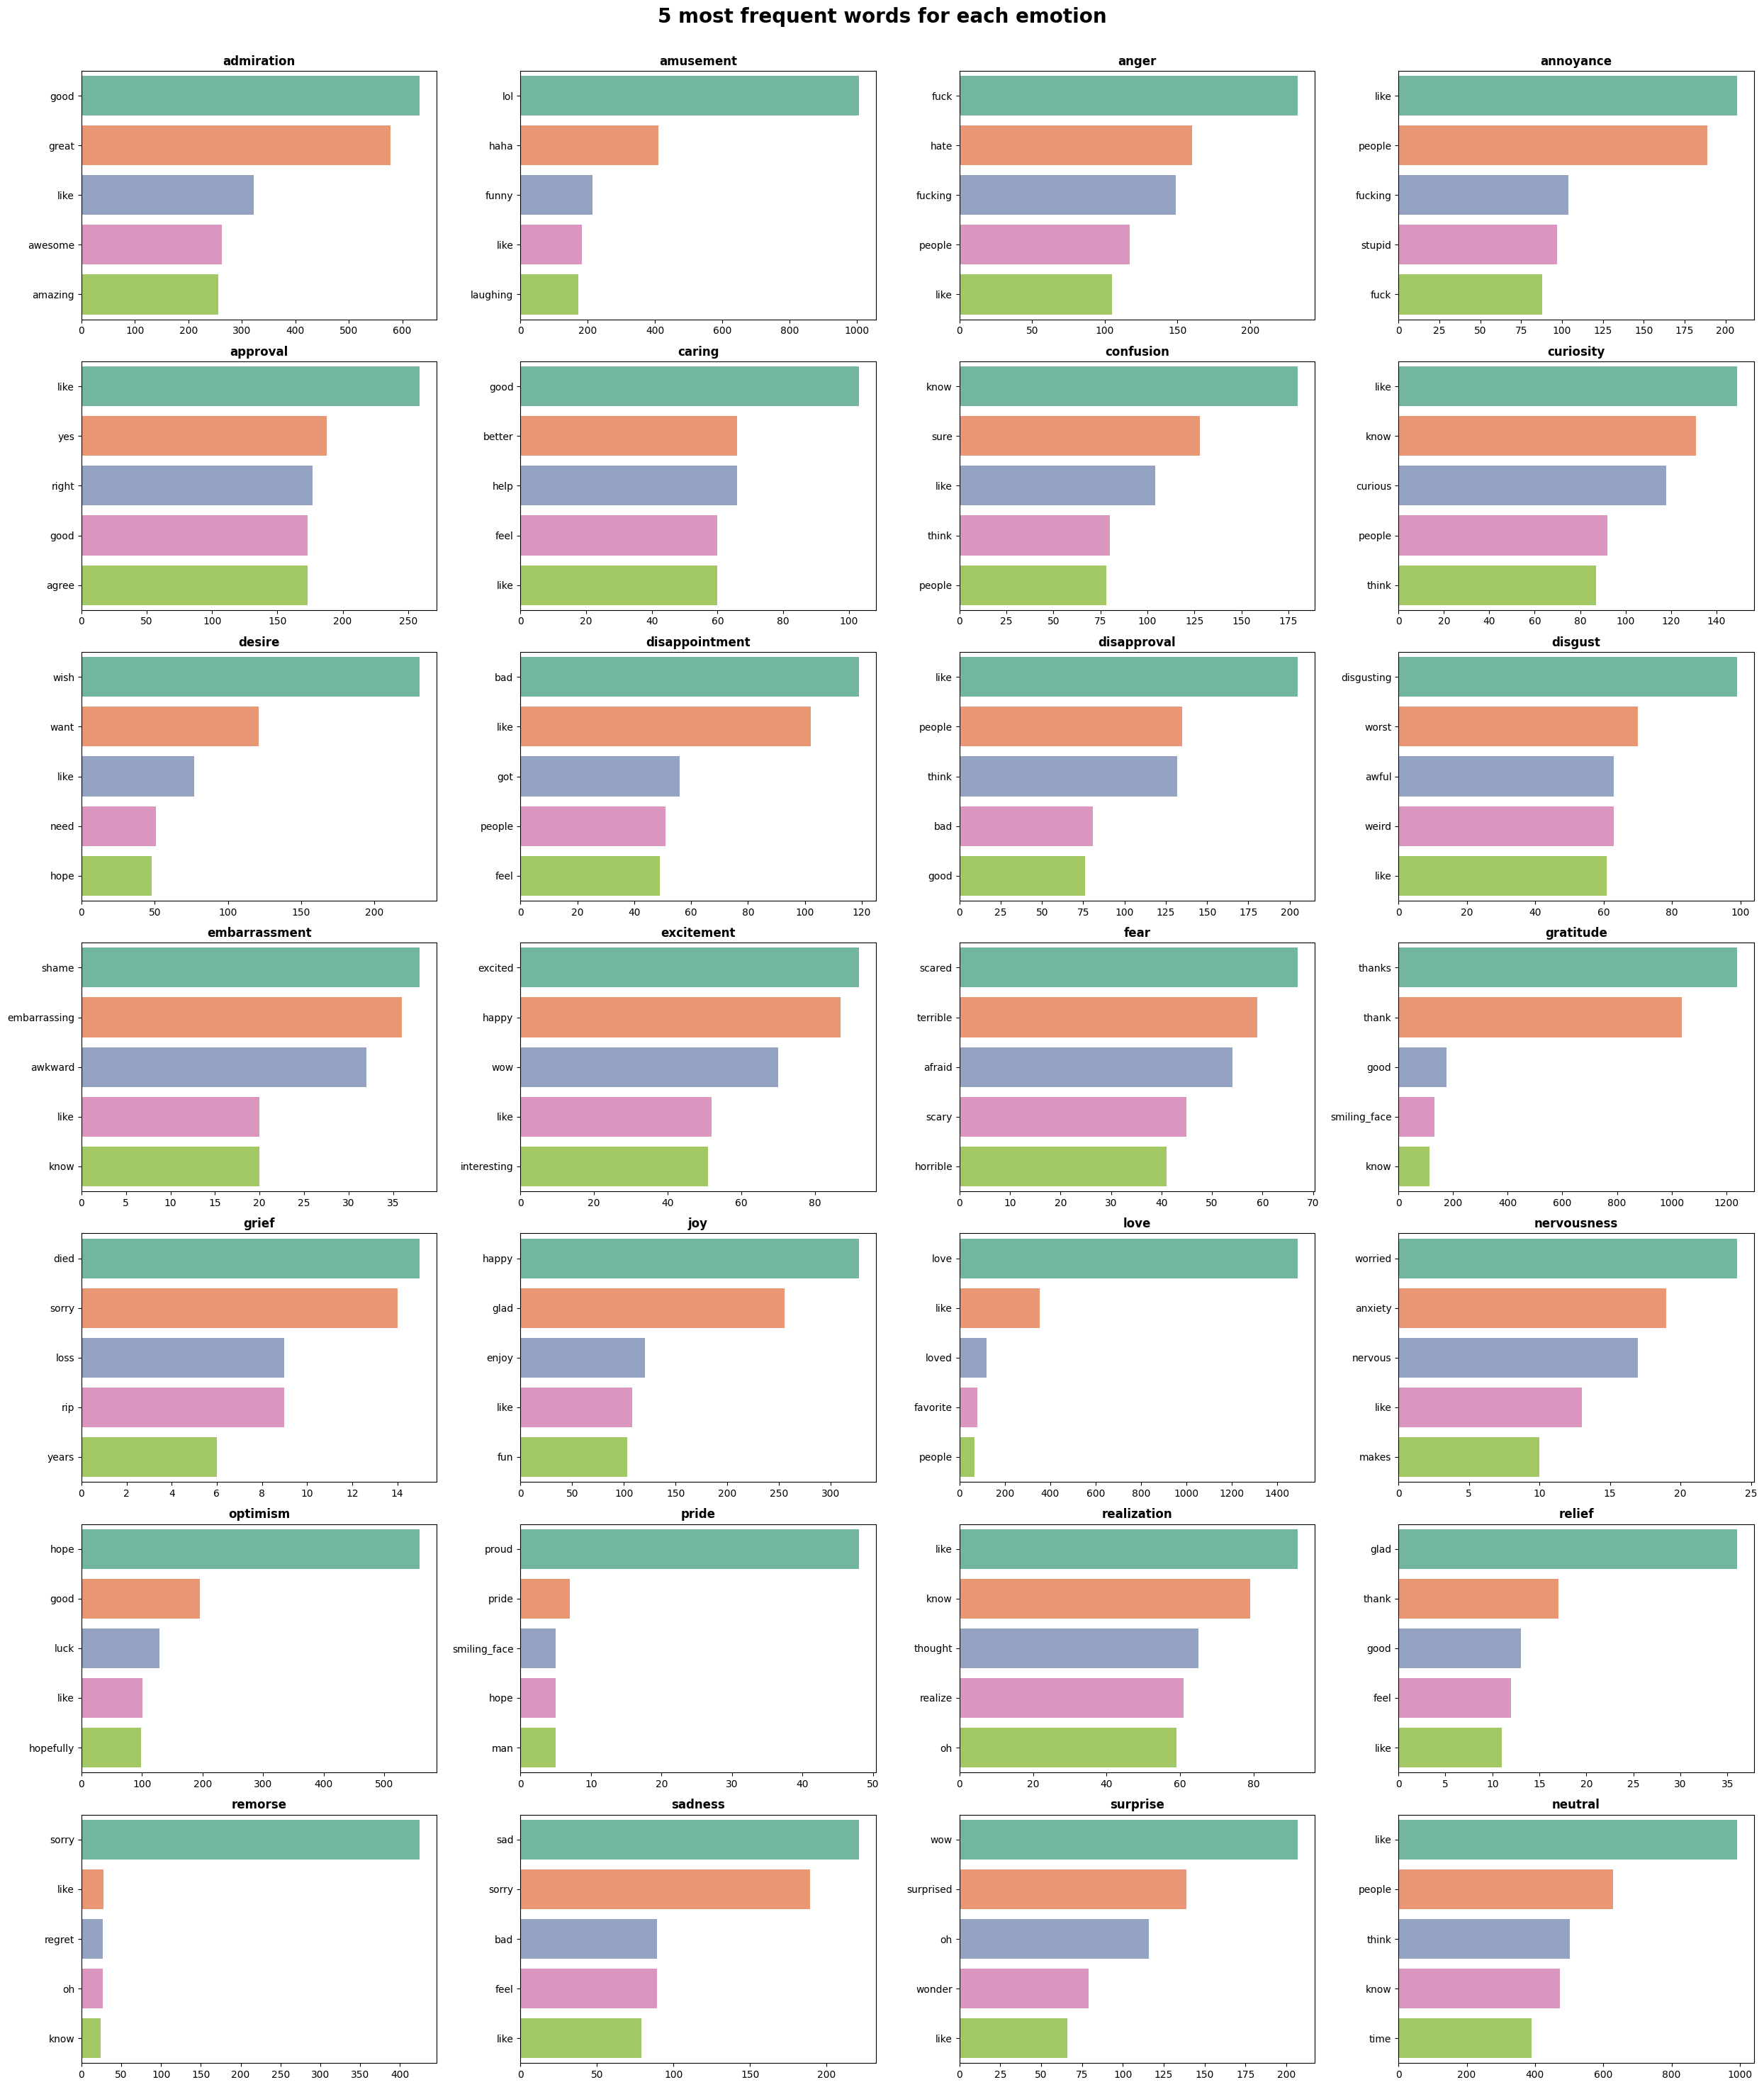

In [ ]:
# Displaying 5 most frequent words for each emotion
fig, axes = plt.subplots(7, 4, figsize=(25, 30))
fig.suptitle('5 most frequent words for each emotion', fontweight="bold", fontsize=20)

for i, axi in enumerate(axes.flat):
    plot_frequent_words(GE_train.loc[GE_train[Emotions[i]]==1,"Clean_text"], axi)
    axi.set_title(Emotions[i], fontweight="bold")

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#Baseline Model- Ridge Classifier

This is a straightforward model that transforms the target variables into {-1, 1} and approaches the problem as a standard regression task.

##**1. Additional preprocessings for basic Machine Learning tasks**

Samples are tokenized using SpaCy's English model. After tokenization, tokens are lemmatized, and English stop words that may not help in the classification task can be removed.

In [9]:
# Creating tokenized documents
tokenized_GE_train = GE_train["Clean_text"].apply(lambda desc: nlp(desc))
tokenized_GE_test = GE_test["Clean_text"].apply(lambda desc: nlp(desc))

In [10]:
# Lemmatize each token and removing english stopwords
tokenized_GE_train = tokenized_GE_train.apply(lambda x: [token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])
tokenized_GE_test = tokenized_GE_test.apply(lambda x: [token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])

# Creating clean data in our dataframes
GE_train["Clean_token"] = [" ".join(x) for x in tokenized_GE_train]
GE_test["Clean_token"] = [" ".join(x) for x in tokenized_GE_test]

**2. TF-IDF Matrix**

In [ ]:
# TF-IDF vector with 1000 words vocabulary
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

# Fitting the vectorizer and transforming train and test data
tfidf_GE_train = vectorizer.fit_transform(GE_train['Clean_token'])
tfidf_GE_test = vectorizer.transform(GE_test['Clean_token'])

# Transforming from generators to arrays
tfidf_GE_train = tfidf_GE_train.toarray()
tfidf_GE_test = tfidf_GE_test.toarray()

In [ ]:
# Validating the shape of train and test data
print(tfidf_GE_train.shape)
print(tfidf_GE_test.shape)

(43410, 1000)
(5427, 1000)


 Each sample in the training and testing datasets will be represented as a vector with dimensions (1, 1000).

In [ ]:
# Defining train and test variables
X_train =  tfidf_GE_train
y_train = GE_train.loc[:,Emotions].values

X_test =  tfidf_GE_test
y_test = GE_test.loc[:,Emotions].values

# Shape validation
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print()
print("The shape of X_test is : ", X_test.shape)
print("The shape of y_test is : ", y_test.shape)

The shape of X_train is :  (43410, 1000)
The shape of y_train is :  (43410, 28)

The shape of X_test is :  (5427, 1000)
The shape of y_test is :  (5427, 28)


##**3. Model Training**

In [ ]:
 rc = RidgeClassifier(class_weight='balanced')  # addressing class imbalance
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced'),
                      n_jobs=-1)

In [ ]:
#Making predictions
classifier_preds = classifier.predict(X_test)
classifier_preds

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]])


### **Model Evaluation**  
To evaluate the model, **F1-score is utilized as the primary metric**. The F1-score provides a balance between recall and precision, making it particularly valuable for handling imbalanced datasets.  

A custom function is defined to compute the F1-score, precision, and recall for each emotion individually, as well as to calculate the macro-average of these metrics to serve as a global evaluation measure.

In [ ]:
# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results


In [ ]:
# Model evaluation
model_eval(y_test, classifier_preds, Emotions)

,Precision,Recall,F1
admiration,0.39,0.72,0.50
amusement,0.58,0.91,0.71
anger,0.15,0.66,0.24
annoyance,0.14,0.59,0.22
approval,0.15,0.66,0.24
caring,0.08,0.59,0.14
confusion,0.07,0.61,0.13
curiosity,0.08,0.57,0.15
desire,0.10,0.69,0.18
disappointment,0.06,0.50,0.10


The Macro-average scores are really low. But it can be improved using a more advanced model.

**Prediction using the model**

Define a function that makes predictions based on a text sample.





In [ ]:
def predict_samples(text_samples, model):

    # Text preprocessing and cleaning
    text_samples = pd.Series(text_samples)
    text_samples_clean = text_samples.apply(preprocess_text)

    # Create tfidf representation
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)

    # labels predictions
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [Emotions[i] for i in range(len(x)) if x[i]==1], axis=1)

    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [ ]:
# Predict samples
predict_samples("no one cares my guy", classifier)


,Text,Emotions
0,no one cares my guy,"[curiosity, neutral]"


**Results**

The low macro-average score of this model can be attributed to its limitation of analyzing words in a text sample based solely on their individual importance, without accounting for the contextual relationships between them (treating the sample as a collection of independent words).  

In the next phase, this limitation will be addressed by employing a more sophisticated algorithm that utilizes the "attention" mechanism—specifically, the BERT model.



---



#BERT (Bidirectional Encoder Representations from Transformers)

**BERT** stands for **Bidirectional Encoder Representations from Transformers**.

It is a transformer-based deep learning model developed by Google for natural language processing (NLP) tasks. By using bidirectional training, BERT captures the context of a word based on the words both before and after it, making it highly effective for various NLP applications such as text classification, sentiment analysis, and question answering.

In [ ]:
# Computing max length of samples
full_text = pd.concat([GE_train['Clean_text'], GE_val['Clean_text'], GE_test['Clean_text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
print(max_length)

48


In [ ]:
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Creating a BERT based model

Model Training

In [ ]:
# function for creating BERT based model
def create_model(nb_labels):

  # Load the MainLayer
  bert = transformer_model.layers[0]

  # Build the model inputs
  input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
  attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
  token_type_ids = Input(shape=(max_length,), name='token_type_ids', dtype='int32') # Changed argument name to token_type_ids
  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids} # Changed argument name to token_type_ids

  # Load the Transformers BERT model as a layer in a Keras model
  bert_model = bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])[1] # Pass inputs as separate keyword arguments
  dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
  pooled_output = dropout(bert_model, training=False)

  # Then build the model output
  emotion = Dense(units=nb_labels, activation="sigmoid", kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
  outputs = emotion

  # And combine it all in a model object
  model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel')

  return model

In [ ]:
# Creating a model instance
model = create_model(28)

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 48)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0]

1. Tokenizing data

First, the texts will be separated from the labels in the training, validation, and test datasets. Then, the BERT tokenizer will be used to tokenize the texts.

In [ ]:
# Creating train, validation and test variables
X_train = GE_train['Clean_text']
y_train = GE_train.loc[:, Emotions].values.astype(float)

X_val = GE_val['Clean_text']
y_val = GE_val.loc[:, Emotions].values.astype(float)

X_test = GE_test['Clean_text']
y_test = GE_test.loc[:, Emotions].values.astype(float)

# Tokenizing train data
train_token = tokenizer(
    text = X_train.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

# Tokenizing validation data
val_token = tokenizer(
    text = X_val.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

# Tokenizing test data
test_token = tokenizer(
    text = X_test.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [ ]:
# Creating BERT compatible inputs with Input Ids, attention masks and token Ids
train = {'input_ids': train_token['input_ids'], 'attention_mask': train_token['attention_mask'],'token_type_ids': train_token['token_type_ids']} # Changed 'token_ids' to 'token_type_ids'
val = {'input_ids': val_token['input_ids'], 'attention_mask': val_token['attention_mask'],'token_type_ids': val_token['token_type_ids']} # Changed 'token_ids' to 'token_type_ids'
test = {'input_ids': test_token['input_ids'], 'attention_mask': test_token['attention_mask'],'token_type_ids': test_token['token_type_ids']} # Changed 'token_ids' to 'token_type_ids'

# Creating TF tensors
train_tensor = tf.data.Dataset.from_tensor_slices((train, y_train)).shuffle(len(train)).batch(16)
val_tensor = tf.data.Dataset.from_tensor_slices((val, y_val)).shuffle(len(val)).batch(16)
test_tensor = tf.data.Dataset.from_tensor_slices((test, y_test)).shuffle(len(test)).batch(16)

2. Class weights and custom loss function

During training, it is essential to monitor the loss function and additional metrics to evaluate the model's performance over the epochs.

To address the multi-label classification scenario, a weighted loss function must be defined to incorporate class weights effectively.

As a first step, class weights need to be computed.


In [ ]:
# Function for calculating multilabel class weights
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        # Change classes to a numpy array
        weights[i] = compute_class_weight(classes=np.array([0.,1.]), y=y_true[:, i], class_weight='balanced') # Updated line
    return weights

class_weights = calculating_class_weights(y_train)

In [ ]:
# Custom loss function for multilabel
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss


3. Model Training

In [ ]:
# Set an optimizer
optimizer = Adam(
    learning_rate=5.e-05,
    )

# Set loss
loss = get_weighted_loss(class_weights)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss)

# train the model
history = model.fit(train_tensor,
                    epochs=4,
                    validation_data=val_tensor,
                    )

Epoch 1/4
2714/2714 [==============================] - 6768s 2s/step - loss: 0.4416 - val_loss: 0.3592
Epoch 2/4
2714/2714 [==============================] - 6873s 3s/step - loss: 0.3022 - val_loss: 0.3543
Epoch 3/4
2714/2714 [==============================] - 6907s 3s/step - loss: 0.2408 - val_loss: 0.3628
Epoch 4/4
2714/2714 [==============================] - 6842s 3s/step - loss: 0.1921 - val_loss: 0.4047


In [ ]:
# Save model weights
model.save_weights('/content/drive/MyDrive/Dissertation/bert-weights.keras')

4. Model Evaluation

In [ ]:
# Making probability predictions on test data
y_pred_proba = model.predict(test)

170/170 [==============================] - 239s 1s/step


Predictions initially produce probabilities for each label. To obtain actual labels, an additional step is required to convert these probabilities into labels based on a specified threshold.

A function is defined for this purpose, with the default threshold set at 0.5.

In [ ]:
# from probabilities to labels using a given threshold
def proba_to_labels(y_pred_proba, threshold=0.5):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

In [ ]:
# Generate labels
y_pred_labels = proba_to_labels(y_pred_proba)

In [ ]:
 #Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary", zero_division=0)

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro", zero_division=0)

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results


In [ ]:
# Model evaluation
model_eval(y_test, y_pred_labels, Emotions)

,Precision,Recall,F1
admiration,0.44,0.86,0.58
amusement,0.55,0.97,0.70
anger,0.21,0.81,0.34
annoyance,0.16,0.82,0.26
approval,0.17,0.69,0.28
caring,0.22,0.68,0.33
confusion,0.17,0.88,0.29
curiosity,0.34,0.93,0.49
desire,0.10,0.86,0.17
disappointment,0.10,0.74,0.18



Threshold Optimization


Define a function that tests a certain number of possible thresholds, and returns the best threshold together with the best predicted labels and best macro f1-score.

In [ ]:
# Function that computes labels from probabilities and optimizes the threshold that maximizes f1-score
def proba_to_labels_opt(y_true, y_pred_proba):

    '''
    Inputs:
        y_true: Ground truth labels
        y_pred_proba: predicted probabilities

    Outputs :
        best_y_pred_labels: preticted labels associated with best threshold
        best_t: best threshold
        best_macro_f1: macro f1-score associated with predicted labels
    '''

    # range of possible thresholds
    thresholds = np.arange(0.7, 0.99, 0.01)

    # Computing threshold that maximizes macro f1-score
    best_y_pred_labels = np.zeros_like(y_pred_proba)
    best_t = 0
    best_macro_f1 = 0

    # Iterating through possible thresholds
    for t in thresholds:

        y_pred_labels = proba_to_labels(y_pred_proba, t)

        _, _, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_t = t
            best_y_pred_labels = y_pred_labels

    return best_y_pred_labels, best_t, best_macro_f1

In [ ]:
# Compute label predictions and corresponding optimal thresholds
y_pred_labels_opt, threshold_opt, macro_f1_opt = proba_to_labels_opt(y_test, y_pred_proba)
print("The model's threshold is {}".format(threshold_opt))
print("The model's best macro-f1 is {}".format(macro_f1_opt))


The model's threshold is 0.9200000000000002
The model's best macro-f1 is 0.4233971261861784


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Model evaluation : Precision, Recall, F-score
model_eval(y_test, y_pred_labels_opt, Emotions)

,Precision,Recall,F1
admiration,0.67,0.57,0.61
amusement,0.72,0.89,0.79
anger,0.44,0.46,0.45
annoyance,0.32,0.24,0.27
approval,0.53,0.23,0.32
caring,0.38,0.39,0.38
confusion,0.29,0.46,0.36
curiosity,0.44,0.78,0.57
desire,0.17,0.60,0.27
disappointment,0.26,0.29,0.27


The model's Macro F1-score and Recall improved significantly after optimizing the threshold.

##3. Handling Predictions with No Labels  
Since the threshold is high, the model sometimes predicts probabilities below the threshold for all labels in a sample. This means the model doesn't detect any emotions for those samples.

In [ ]:
# Number of predictions with no positive label
sum(np.sum(y_pred_labels_opt, axis=1)==0)

733

One strategy to handle this is to assign the 'Neutral' emotion, as it is the most common one and makes sense when no other emotion is detected.

In [ ]:
# Handling emoty label predictions
y_pred_labels_opt_n = np.copy(y_pred_labels_opt)

# if no predictions ==> neutral
for pred in y_pred_labels_opt_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_test, y_pred_labels_opt_n, Emotions)

,Precision,Recall,F1
admiration,0.67,0.57,0.61
amusement,0.72,0.89,0.79
anger,0.44,0.46,0.45
annoyance,0.32,0.24,0.27
approval,0.53,0.23,0.32
caring,0.38,0.39,0.38
confusion,0.29,0.46,0.36
curiosity,0.44,0.78,0.57
desire,0.17,0.60,0.27
disappointment,0.26,0.29,0.27


This strategy slightly improved Macro Recall and F1-score.But it did not have any significant impact on Macro F1-score.

##Model Predictions

In [ ]:
def predict_samples(text_samples, model, threshold):

    # Text preprocessing and cleaning
    text_samples_clean = [preprocess_text(text) for text in text_samples]

    # Tokenizing train data
    samples_token = tokenizer(
        text = text_samples_clean,
        add_special_tokens = True,
        max_length = max_length,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True,
    )

    # Preparing to feed the model
    samples = {'input_ids': samples_token['input_ids'],
               'attention_mask': samples_token['attention_mask'],
               'token_type_ids': samples_token['token_type_ids']
              }

    # Probability predictions
    samples_pred_proba = model.predict(samples)

    # Label prediction using threshold
    samples_pred_labels = proba_to_labels(samples_pred_proba)

    # if no predictions ==> neutral
    for pred in samples_pred_labels:
        if pred.sum()==0:
            pred[-1]=1

    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [Emotions[i] for i in range(len(x)) if x[i]==1], axis=1)

    #return list(samples_pred_labels_df)
    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [ ]:
# Predict samples
predict_samples(["My favourite food is anything I didn't have to cook myself", "are you kiddin me ??!!", "my advice is that you should see a doctor", "a dog in the park"], model, threshold_opt)


1/1 [==============================] - 0s 279ms/step


,Text,Emotions
0,My favourite food is anything I didn't have to...,"[admiration, approval, joy, love, pride]"
1,are you kiddin me ??!!,"[annoyance, confusion, curiosity, surprise]"
2,my advice is that you should see a doctor,"[approval, caring, neutral]"
3,a dog in the park,[neutral]


**Results:**

Some detected emotions are inconsistent. The 'Neutral' label was often used as a "catch-all" for unclear cases, and some samples were labeled with both 'Neutral' and other emotions, which is contradictory. This noisy data may cause confusion between emotions. A new model will be trained without the 'Neutral' samples.


##Removing "Neutral" Label

In [4]:
# Importing train, validation and test datasets with preprocessed texts and labels
GE_train = pd.read_csv("/content/drive/MyDrive/Dissertation/Data/train_clean.csv")
GE_val = pd.read_csv("/content/drive/MyDrive/Dissertation/Data/val_clean.csv")
GE_test = pd.read_csv("/content/drive/MyDrive/Dissertation/Data/test_clean.csv")

# Shape validation
print(GE_train.shape)
print(GE_val.shape)
print(GE_test.shape)


(43410, 29)
(5426, 29)
(5427, 29)


In [5]:
# Loading emotion labels
with open("/content/drive/MyDrive/Dissertation/Data/emotions.txt", "r") as file:
    Emotions = file.read().split("\n")
Emotions.remove('neutral')
print("\nCurrent Emotions in the data are : \n{}".format(Emotions))


Current Emotions in the data are : 
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']


In [6]:
GE_train = GE_train.drop(columns=['neutral'])
GE_val = GE_val.drop(columns=['neutral'])
GE_test = GE_test.drop(columns=['neutral'])

In [7]:
# Removing samples with only 0 in their labels
GE_train = GE_train.loc[GE_train.iloc[:, 1:].sum(axis=1) > 0]
GE_val = GE_val.loc[GE_val.iloc[:, 1:].sum(axis=1) > 0]
GE_test = GE_test.loc[GE_test.iloc[:, 1:].sum(axis=1) > 0]



In [8]:
# Verify the shape of the datasets
print(GE_train.shape)
print(GE_val.shape)
print(GE_test.shape)

(30587, 28)
(3834, 28)
(3821, 28)


In [11]:
# Preview of data
display(GE_train.head(3))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dirty southern wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Save the DataFrames as CSV files in the specified path
GE_train.to_csv("/content/drive/MyDrive/Dissertation/Data/traindata_without_neutral.csv", index=False)
GE_val.to_csv("/content/drive/MyDrive/Dissertation/Data/valdata_without_neutral.csv", index=False)
GE_test.to_csv("/content/drive/MyDrive/Dissertation/Data/testdata_without_neutral.csv", index=False)

print("Files saved to Drive")


Files saved to Drive


Re-Configuration of the BERT model

In [9]:
# Computing max length of samples
full_text = pd.concat([GE_train['Clean_text'], GE_val['Clean_text'], GE_test['Clean_text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
print(max_length)

48


In [39]:
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model Training

In [40]:
# function for creating BERT based model
def create_model(nb_labels):

  # Load the MainLayer
  bert = transformer_model.layers[0]

  # Build the model inputs
  input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
  attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
  token_type_ids = Input(shape=(max_length,), name='token_type_ids', dtype='int32')
  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}

  # Load the Transformers BERT model as a layer in a Keras model
  bert_model = bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])[1] # Pass inputs as separate keyword arguments
  dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
  pooled_output = dropout(bert_model, training=False)

  # Then build the model output
  emotion = Dense(units=nb_labels, activation="sigmoid", kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
  outputs = emotion

  # And combine it all in a model object
  model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel')

  return model

In [41]:
# Creating a model instance
model = create_model(27)

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 48)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0]

Tokenizing data

In [42]:
# Creating train, validation and test variables
X_train = GE_train['Clean_text']
y_train = GE_train.loc[:, Emotions].values.astype(float)

X_val = GE_val['Clean_text']
y_val = GE_val.loc[:, Emotions].values.astype(float)

X_test = GE_test['Clean_text']
y_test = GE_test.loc[:, Emotions].values.astype(float)

# Tokenizing train data
train_token = tokenizer(
    text = X_train.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

# Tokenizing validation data
val_token = tokenizer(
    text = X_val.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

# Tokenizing test data
test_token = tokenizer(
    text = X_test.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [43]:
# Creating BERT compatible inputs with Input Ids, attention masks and token Ids
train = {'input_ids': train_token['input_ids'], 'attention_mask': train_token['attention_mask'],'token_type_ids': train_token['token_type_ids']} # Changed 'token_ids' to 'token_type_ids'
val = {'input_ids': val_token['input_ids'], 'attention_mask': val_token['attention_mask'],'token_type_ids': val_token['token_type_ids']} # Changed 'token_ids' to 'token_type_ids'
test = {'input_ids': test_token['input_ids'], 'attention_mask': test_token['attention_mask'],'token_type_ids': test_token['token_type_ids']} # Changed 'token_ids' to 'token_type_ids'

# Creating TF tensors
train_tensor = tf.data.Dataset.from_tensor_slices((train, y_train)).shuffle(len(train)).batch(16)
val_tensor = tf.data.Dataset.from_tensor_slices((val, y_val)).shuffle(len(val)).batch(16)
test_tensor = tf.data.Dataset.from_tensor_slices((test, y_test)).shuffle(len(test)).batch(16)

2. Class weights and custom loss function

In [44]:
# Function for calculating multilabel class weights
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        # Change classes to a numpy array
        weights[i] = compute_class_weight(classes=np.array([0.,1.]), y=y_true[:, i], class_weight='balanced') # Updated line
    return weights

class_weights = calculating_class_weights(y_train)

In [45]:
# Custom loss function for multilabel
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss


3. Model Training

In [46]:
# Set an optimizer
optimizer = Adam(
    learning_rate=3.e-05,
    )

# Set loss
loss = get_weighted_loss(class_weights)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss)

# train the model
history = model.fit(train_tensor,
                    epochs=3,
                    validation_data=val_tensor,
                    )

Epoch 1/3
1912/1912 [==============================] - 3301s 2s/step - loss: 0.4350 - val_loss: 0.3398
Epoch 2/3
1912/1912 [==============================] - 3212s 2s/step - loss: 0.2830 - val_loss: 0.2992
Epoch 3/3
1912/1912 [==============================] - 3205s 2s/step - loss: 0.2111 - val_loss: 0.3092


4. Model Evaluation

In [47]:
# Making probability predictions on test data
y_pred_proba = model.predict(test)

120/120 [==============================] - 97s 783ms/step


4.1 Using Default Threshold - 0.5

In [48]:
# from probabilities to labels using a given threshold
def proba_to_labels(y_pred_proba, threshold=0.5):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

In [49]:
# Generate labels
y_pred_labels = proba_to_labels(y_pred_proba)

In [50]:
 #Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary", zero_division=0)

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro", zero_division=0)

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results


In [51]:
# Model evaluation
model_eval(y_test, y_pred_labels, Emotions)

,Precision,Recall,F1
admiration,0.64,0.79,0.71
amusement,0.66,0.95,0.78
anger,0.35,0.81,0.49
annoyance,0.31,0.70,0.43
approval,0.36,0.71,0.47
caring,0.24,0.84,0.37
confusion,0.23,0.92,0.36
curiosity,0.40,0.93,0.56
desire,0.21,0.83,0.33
disappointment,0.16,0.66,0.26


2. Using Threshold Optimization

Define a function that tests a certain number of possible thresholds, and returns the best threshold together with the best predicted labels and best macro f1-score.

In [36]:
# Function that computes labels from probabilities and optimizes the threshold that maximizes f1-score
def proba_to_labels_opt(y_true, y_pred_proba):

    '''
    Inputs:
        y_true: Ground truth labels
        y_pred_proba: predicted probabilities

    Outputs :
        best_y_pred_labels: preticted labels associated with best threshold
        best_t: best threshold
        best_macro_f1: macro f1-score associated with predicted labels
    '''

    # range of possible thresholds
    thresholds = np.arange(0.7, 0.99, 0.01)

    # Computing threshold that maximizes macro f1-score
    best_y_pred_labels = np.zeros_like(y_pred_proba)
    best_t = 0
    best_macro_f1 = 0

    # Iterating through possible thresholds
    for t in thresholds:

        y_pred_labels = proba_to_labels(y_pred_proba, t)

        _, _, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_t = t
            best_y_pred_labels = y_pred_labels

    return best_y_pred_labels, best_t, best_macro_f1

In [53]:
# Compute label predictions and corresponding optimal thresholds
y_pred_labels_opt, threshold_opt, macro_f1_opt = proba_to_labels_opt(y_test, y_pred_proba)
print("The model's threshold is {}".format(threshold_opt))
print("The model's best macro-f1 is {}".format(macro_f1_opt))


The model's threshold is 0.8900000000000001
The model's best macro-f1 is 0.504850139697112


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
 #Evaluation Metrics : Precision, Recall, F-score
model_eval(y_test, y_pred_labels_opt, Emotions)

,Precision,Recall,F1
admiration,0.82,0.54,0.65
amusement,0.81,0.89,0.85
anger,0.56,0.53,0.54
annoyance,0.56,0.25,0.35
approval,0.65,0.32,0.42
caring,0.41,0.59,0.48
confusion,0.39,0.55,0.46
curiosity,0.61,0.80,0.69
desire,0.50,0.60,0.54
disappointment,0.46,0.27,0.34


##Predictions using the model

In [56]:
def predict_samples(text_samples, model, threshold):

    # Text preprocessing and cleaning
    text_samples_clean = [preprocess_text(text) for text in text_samples]

    # Tokenizing train data
    samples_token = tokenizer(
        text = text_samples_clean,
        add_special_tokens = True,
        max_length = max_length,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True,
    )

    # Preparing to feed the model
    samples = {'input_ids': samples_token['input_ids'],
               'attention_mask': samples_token['attention_mask'],
               'token_type_ids': samples_token['token_type_ids']
              }

    # Probability predictions
    samples_pred_proba = model.predict(samples)

    # Label prediction using threshold
    samples_pred_labels = proba_to_labels(samples_pred_proba)

    # if no predictions ==> neutral
    for pred in samples_pred_labels:
        if pred.sum()==0:
            pred[-1]=1

    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [Emotions[i] for i in range(len(x)) if x[i]==1], axis=1)

    #return list(samples_pred_labels_df)
    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [60]:
# Predict samples
predict_samples(["My favourite food is anything I didn't have to cook myself", "are you kiddin me ??!!", "red", "white"], model, threshold_opt)


1/1 [==============================] - 0s 195ms/step


,Text,Emotions
0,My favourite food is anything I didn't have to...,"[approval, joy, love]"
1,are you kiddin me ??!!,"[amusement, confusion, curiosity, surprise]"
2,red,"[anger, annoyance]"
3,white,[approval]


**RESULTS**

The Macro F1-score of BERT is 0.50, which is lower than expected. But, in case of Predictions, the model is performing exceptionally well. The emotions in the sample texts are predicted correctly, even for texts without any context, like "red" and "white", it is giving proper predictions.



---



##DISTILBERT

In [10]:
#Verifying the shape of train, val, test datasets
print(GE_train.shape)
print(GE_val.shape)
print(GE_test.shape)


(30587, 28)
(3834, 28)
(3821, 28)


The DistilBERT model is trained on a dataset where the 'Neutral' column has been dropped, resulting in a reduction in dataset size.

1. Tokenizing the data

In [12]:
# Computing max length
full_text = pd.concat([GE_train['Clean_text'], GE_val['Clean_text'], GE_test['Clean_text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
print(max_length)

48


In [13]:
# Setting up tokenizer
model_name = 'distilbert-base-uncased'
config = DistilBertConfig.from_pretrained(model_name, output_hidden_states=False)
tokenizer = DistilBertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)
transformer_model = TFDistilBertModel.from_pretrained(model_name, config=config)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


2. DistilBERT Model Architecture

In [15]:
# Creating DistilBERT-based model
def create_distilbert_model(nb_labels):
    distilbert = transformer_model.layers[0]  # Load the DistilBERT main layer

    # Define model inputs
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
    inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

    # Add the DistilBERT layer
    distilbert_model = transformer_model(inputs)[0][:, 0, :]  # First token output (CLS)
    dropout = Dropout(config.dropout, name='pooled_output')
    pooled_output = dropout(distilbert_model, training=False)

    # Output layer
    emotion = Dense(units=nb_labels, activation='sigmoid', name='emotion')(pooled_output)

    # Build model
    model = Model(inputs=inputs, outputs=emotion, name='DistilBERT_MultiLabel')
    return model

# Instantiate model
distilbert_model = create_distilbert_model(len(Emotions))
distilbert_model.summary()


Model: "DistilBERT_MultiLabel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 48)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['attention_mask[0][0]',         
 ilBertModel)                   ast_hidden_state=(N               'input_ids[0][0]']              
                                one, 48, 768),                                                    
                                 hidden_states=None                           

3. Tokenizing Data

In [16]:
# Tokenizing datasets
def tokenize_data(data, tokenizer, max_length):
    tokens = tokenizer(
        text=data.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}

train = tokenize_data(GE_train['Clean_text'], tokenizer, max_length)
val = tokenize_data(GE_val['Clean_text'], tokenizer, max_length)
test = tokenize_data(GE_test['Clean_text'], tokenizer, max_length)

# Creating TensorFlow datasets
y_train = GE_train.loc[:, Emotions].values.astype(float)
y_val = GE_val.loc[:, Emotions].values.astype(float)
y_test = GE_test.loc[:, Emotions].values.astype(float)

train_tensor = tf.data.Dataset.from_tensor_slices((train, y_train)).shuffle(len(train['input_ids'])).batch(16)
val_tensor = tf.data.Dataset.from_tensor_slices((val, y_val)).shuffle(len(val['input_ids'])).batch(16)
test_tensor = tf.data.Dataset.from_tensor_slices((test, y_test)).shuffle(len(test['input_ids'])).batch(16)

4. Compute Class Weights and Define Loss Function

In [17]:
# Calculate class weights
def calculate_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight='balanced', classes=np.array([0., 1.]), y=y_true[:, i])
    return weights

class_weights = calculate_class_weights(y_train)

# Define custom loss function
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        weights_per_sample = tf.reduce_sum(weights[:, 1] * y_true + weights[:, 0] * (1 - y_true), axis=-1)
        return tf.reduce_mean(weights_per_sample * tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss



4. Compile and Train Model

In [72]:
# Compile model
distilbert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                         loss=get_weighted_loss(class_weights))

# Train model
history = distilbert_model.fit(train_tensor,
                              epochs=3,
                              validation_data=val_tensor)


Epoch 1/3
1912/1912 [==============================] - 1804s 937ms/step - loss: 3.3003 - val_loss: 2.7534
Epoch 2/3
1912/1912 [==============================] - 1778s 930ms/step - loss: 2.4405 - val_loss: 2.6951
Epoch 3/3
1912/1912 [==============================] - 1805s 944ms/step - loss: 1.9882 - val_loss: 2.7402


In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/Dissertation/DistilBERT_model')

print("DistilBERT model saved successfully!")


5. Model Evaluation

In [27]:
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

# Load the saved model with custom objects
with custom_object_scope({'weighted_loss': get_weighted_loss(class_weights)}):
    distilbert_model = load_model('/content/drive/MyDrive/Dissertation/DistilBERT_Model')


print("DistilBERT model loaded successfully!")


DistilBERT model loaded successfully!


In [30]:
# Making probability predictions on test data
y_pred_proba = distilbert_model.predict(test)

120/120 [==============================] - 67s 547ms/step


5.1 Using Default threshold 0.7

In [40]:
# from probabilities to labels using a given threshold
def proba_to_labels(y_pred_proba, threshold=0.7):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

In [41]:
# Generate labels
y_pred_labels = proba_to_labels(y_pred_proba)

In [42]:
 #Model evaluation function
def distilbert_model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary", zero_division=0)

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro", zero_division=0)

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results


In [43]:
# Model evaluation
distilbert_model_eval(y_test, y_pred_labels, Emotions)

,Precision,Recall,F1
admiration,0.79,0.62,0.70
amusement,0.84,0.89,0.87
anger,0.75,0.34,0.47
annoyance,0.77,0.09,0.17
approval,0.78,0.25,0.37
caring,0.62,0.41,0.50
confusion,0.71,0.39,0.51
curiosity,0.78,0.15,0.25
desire,0.77,0.48,0.59
disappointment,0.73,0.11,0.18


###5.2  Threshold optimization

Define a function that tests a certain number of possible thresholds, and returns the best threshold together with the best predicted labels and best macro f1-score.

In [48]:
# Function that computes labels from probabilities and optimizes the threshold that maximizes f1-score
def proba_to_labels_opt(y_true, y_pred_proba):

    '''
    Inputs:
        y_true: Ground truth labels
        y_pred_proba: predicted probabilities

    Outputs :
        best_y_pred_labels: preticted labels associated with best threshold
        best_t: best threshold
        best_macro_f1: macro f1-score associated with predicted labels
    '''

    # range of possible thresholds
    thresholds = np.arange(0.2, 0.6, 0.01)

    # Computing threshold that maximizes macro f1-score
    best_y_pred_labels = np.zeros_like(y_pred_proba)
    best_t = 0
    best_macro_f1 = 0

    # Iterating through possible thresholds
    for t in thresholds:

        y_pred_labels = proba_to_labels(y_pred_proba, t)

        _, _, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_t = t
            best_y_pred_labels = y_pred_labels

    return best_y_pred_labels, best_t, best_macro_f1

In [49]:

# Compute label predictions and corresponding optimal thresholds
y_pred_labels_opt, threshold_opt, macro_f1_opt = proba_to_labels_opt(y_test, y_pred_proba)
print("The model's threshold is {}".format(threshold_opt))
print("The model's best macro-f1 is {}".format(macro_f1_opt))


The model's threshold is 0.3100000000000001
The model's best macro-f1 is 0.5513616972660577


In [50]:
 #Evaluation Metrics : Precision, Recall, F-score
distilbert_model_eval(y_test, y_pred_labels_opt, Emotions)

,Precision,Recall,F1
admiration,0.67,0.75,0.71
amusement,0.77,0.94,0.85
anger,0.56,0.53,0.55
annoyance,0.50,0.38,0.43
approval,0.56,0.48,0.52
caring,0.41,0.64,0.50
confusion,0.44,0.67,0.53
curiosity,0.69,0.65,0.67
desire,0.58,0.60,0.59
disappointment,0.44,0.23,0.30


##Predictions using the model

In [67]:
def distilbert_predict_samples_random(test_data, distilbert_model, threshold, sample_size):

    # Randomly sample the test data
    sampled_data = test_data.sample(n=sample_size, random_state=random.randint(0, 1000))

    # Extract the text samples from the sampled data
    text_samples = sampled_data['Clean_text'].tolist()

    # Text preprocessing and cleaning
    text_samples_clean = [preprocess_text(text) for text in text_samples]

    # Tokenizing train data
    samples_token = tokenizer(
        text = text_samples_clean,
        add_special_tokens = True,
        max_length = max_length,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True,
    )

    # Preparing to feed the model
    samples = {'input_ids': samples_token['input_ids'],
               'attention_mask': samples_token['attention_mask']
              }

    # Probability predictions
    samples_pred_proba = distilbert_model.predict(samples)

    # Label prediction using threshold
    samples_pred_labels = proba_to_labels(samples_pred_proba)

    # Map predictions to emotion labels
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [Emotions[i] for i in range(len(x)) if x[i]==1], axis=1)

    result_df= pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})
    # Display the DataFrame as an HTML table
    display(HTML(result_df.to_html(index=False, escape=False)))
    return result_df

In [73]:
predicted_df =distilbert_predict_samples_random(GE_test, distilbert_model, threshold_opt, sample_size=5)


1/1 [==============================] - 0s 125ms/step


Text,Emotions
but you appear to think you have some amazing insights on how to handle a pwbpd have you considered the possibility that you do not ?,[]
yard goats was awesome almost a major league feel to it when it is a packed day,[admiration]
thanks ! i had a more standard name but then realized i did not want to be findable on reddit,[gratitude]
i do not trust our defense at all i do not believe you can increase the range of andujar,[disapproval]
i love how you only see these types of comments on japanese games brings out the inner weep,[love]


**Results:**

The Macro-average score is higher than BERT and the model detects emotions that are coherent. Also, samples with no detected emotions is denoted with a [ ] symbol, which is way better than detecting the emotion as neutral.



---



#MACHINE LEARNING MODELS

In [5]:
# Load train, validation and test datasets
GE_train = pd.read_csv("/content/drive/MyDrive/Dissertation/Data/traindata_without_neutral.csv")
GE_val = pd.read_csv("/content/drive/MyDrive/Dissertation/Data/valdata_without_neutral.csv")
GE_test = pd.read_csv("/content/drive/MyDrive/Dissertation/Data/testdata_without_neutral.csv")


In [6]:
#Verifying the shape of train and test dataframes
print(GE_train.shape)
print(GE_val.shape)
print(GE_test.shape)

(30587, 28)
(3834, 28)
(3821, 28)


In [7]:
#preview of train data
display(GE_train.head(3))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,to make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,dirty southern wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Load emotion labels
with open("/content/drive/MyDrive/Dissertation/Data/emotions.txt", "r") as file:
    Emotions = file.read().split("\n")
Emotions.remove('neutral')
print(Emotions)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']


**Additional Preprocessing for Machine Learning models**

Samples are tokenized using SpaCy's English model. After tokenization, tokens are lemmatized, and English stop words that may not help in the classification task can be removed.

In [32]:
# Creating tokenized documents
tokenized_GE_train = GE_train["Clean_text"].apply(lambda desc: nlp(desc))
tokenized_GE_test = GE_test["Clean_text"].apply(lambda desc: nlp(desc))

In [33]:
# Lemmatize each token and removing english stopwords
tokenized_GE_train = tokenized_GE_train.apply(lambda x: [token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])
tokenized_GE_test = tokenized_GE_test.apply(lambda x: [token.lemma_ for token in x if token.lemma_ not in STOP_WORDS])

# Creating clean data in dataframes
GE_train["Clean_token"] = [" ".join(x) for x in tokenized_GE_train]
GE_test["Clean_token"] = [" ".join(x) for x in tokenized_GE_test]

TF-IDF VECTORIZATION

Each sample in the training and testing datasets will be represented as a vector with dimensions (1, 1000).

In [34]:
# TF-IDF vector with 1000 words vocabulary
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

# Fitting the vectorizer and transforming train and test data
tfidf_GE_train = vectorizer.fit_transform(GE_train['Clean_token'])
tfidf_GE_test = vectorizer.transform(GE_test['Clean_token'])

# Transforming from generators to arrays
tfidf_GE_train = tfidf_GE_train.toarray()
tfidf_GE_test = tfidf_GE_test.toarray()

In [35]:
# Validating the shape of train and test data
print(tfidf_GE_train.shape)
print(tfidf_GE_test.shape)

(30587, 1000)
(3821, 1000)


In [46]:
# Defining train and test variables
X_train =  tfidf_GE_train
y_train = GE_train.loc[:,Emotions].values

X_test =  tfidf_GE_test
y_test = GE_test.loc[:,Emotions].values

# Shape validation
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print()
print("The shape of X_test is : ", X_test.shape)
print("The shape of y_test is : ", y_test.shape)

The shape of X_train is :  (30587, 1000)
The shape of y_train is :  (30587, 27)

The shape of X_test is :  (3821, 1000)
The shape of y_test is :  (3821, 27)


1. RIDGE CLASSIFIER - BASELINE MODEL

This is a straightforward model that transforms the target variables into {-1, 1} and approaches the problem as a standard regression task.

1.1 Model Training

In [37]:
 rc = RidgeClassifier(class_weight='balanced')  # addressing class imbalance
classifier = MultiOutputClassifier(rc, n_jobs=-1)
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced'),
                      n_jobs=-1)

In [38]:
#Making predictions
classifier_preds = classifier.predict(X_test)
classifier_preds

array([[0, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

1.2 Model Evaluation

In [39]:
# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results


In [40]:
# Model evaluation
model_eval(y_test, classifier_preds, Emotions)

,Precision,Recall,F1
admiration,0.47,0.71,0.56
amusement,0.64,0.90,0.75
anger,0.22,0.67,0.33
annoyance,0.20,0.63,0.30
approval,0.21,0.71,0.33
caring,0.12,0.62,0.20
confusion,0.10,0.65,0.17
curiosity,0.15,0.63,0.24
desire,0.14,0.66,0.22
disappointment,0.09,0.56,0.16


**Prediction using the model**

Define a function that makes predictions based on a text sample.





In [41]:
def predict_samples(text_samples, model):

    # Text preprocessing and cleaning
    text_samples = pd.Series(text_samples)
    text_samples_clean = text_samples.apply(preprocess_text)

    # Create tfidf representation
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)

    # labels predictions
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [Emotions[i] for i in range(len(x)) if x[i]==1], axis=1)

    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [44]:
# Predict samples
predict_samples("no one cares my guy", classifier)


,Text,Emotions
0,no one cares my guy,"[confusion, curiosity, excitement]"


RESULTS:

The Macro-average scores of Precision, Recall and F1-score have improved after removing the "Neutral" column. For model prediction, the same text is used for comparision and this time, the predictions are more coherent.

2. Logistic Regression